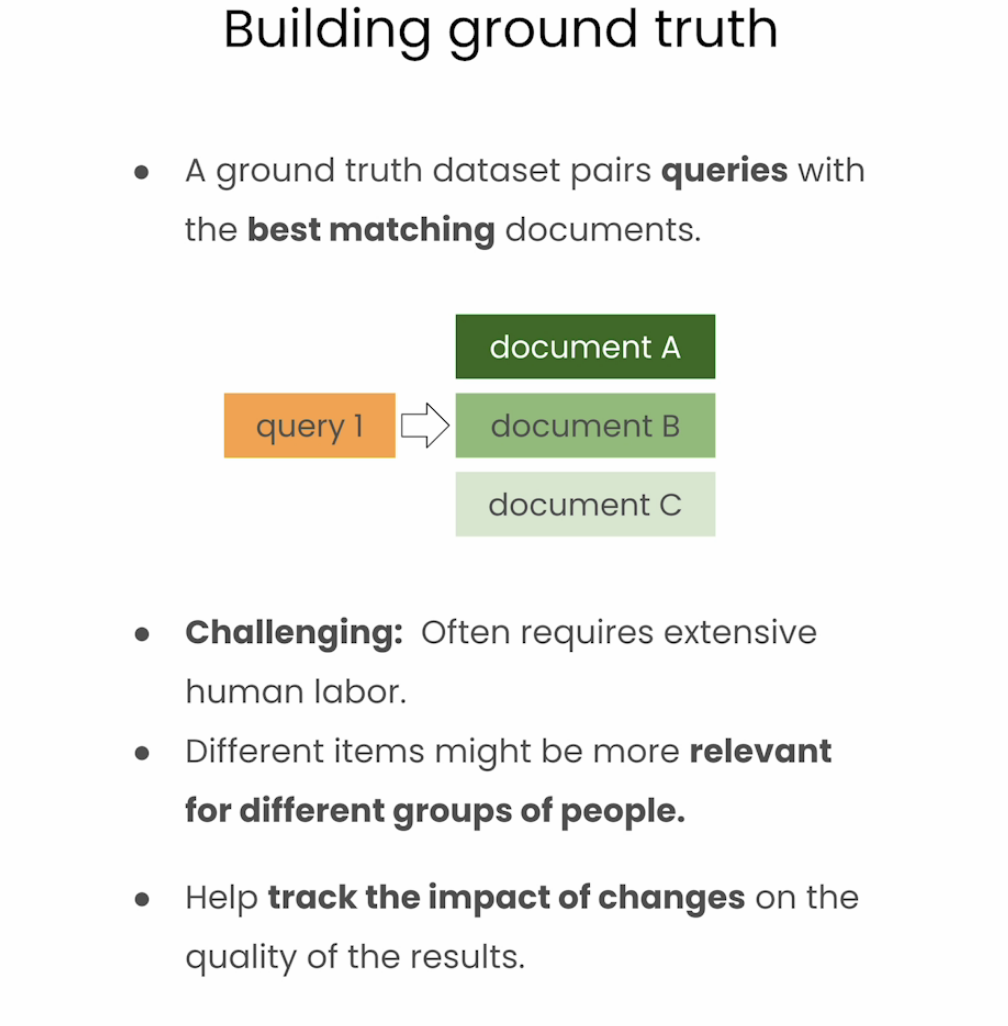
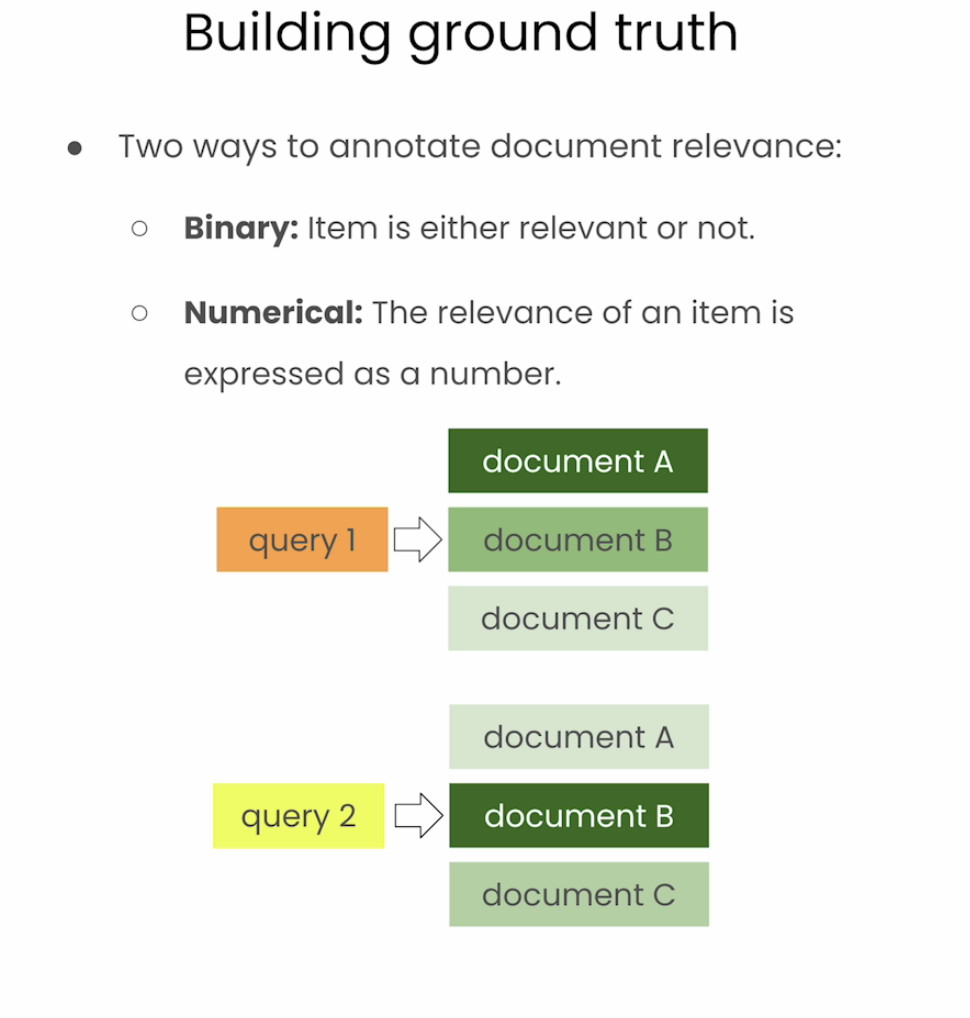

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

products_df = pd.read_csv(
    "https://github.com/wayfair/WANDS/raw/refs/heads/main/dataset/product.csv", 
    sep="\t", 
    index_col="product_id", 
    keep_default_na=False,  # some products do not have a description
)
products_df.head()

product_name  \
product_id                                                      
0                                     solid wood platform bed   
1                                 all-clad 7 qt . slow cooker   
2                     all-clad electrics 6.5 qt . slow cooker   
3                all-clad all professional tools pizza cutter   
4           baldwin prestige alcott passage knob with roun...   

                           product_class  \
product_id                                 
0                                   Beds   
1                           Slow Cookers   
2                           Slow Cookers   
3           Slicers, Peelers And Graters   
4                             Door Knobs   

                                           category hierarchy  \
product_id                                                      
0           Furniture / Bedroom Furniture / Beds & Headboa...   
1           Kitchen & Tabletop / Small Kitchen Appliances ...   
2           Kitchen & Tabletop / Small Kitchen Appliances ...   
3                                  Browse By Brand / All-Clad   
4           Home Improvement / Doors & Door Hardware / Doo...   

                                          product_description  \
product_id                                                      
0           good , deep sleep can be quite difficult to ha...   
1           create delicious slow-cooked meals , from tend...   
2           prepare home-cooked meals on any schedule with...   
3           this original stainless tool was designed to c...   
4           the hardware has a rich heritage of delivering...   

                                             product_features rating_count  \
product_id                                                                   
0           overallwidth-sidetoside:64.7|dsprimaryproducts...         15.0   
1           capacityquarts:7|producttype : slow cooker|pro...        100.0   
2           features : keep warm setting|capacityquarts:6....        208.0   
3           overallwidth-sidetoside:3.5|warrantylength : l...         69.0   
4           compatibledoorthickness:1.375 '' |countryofori...         70.0   

           average_rating review_count  
product_id                              
0                     4.5         15.0  
1                     2.0         98.0  
2                     3.0        181.0  
3                     4.5         42.0  
4                     5.0         42.0

In [4]:
# Start qdrant docker server
!docker run -d --name qdrant -p 6333:6333 -v $(pwd)/qdrant_data:/qdrant_data qdrant/qdrant:latest

614edcf38d990aaadeda9d7e64c46fdebe1a6e1f9d2fb9da75cb97763df48f8e


In [5]:
num_products = 5000

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

product_name_embeddings = model.encode(
    products_df["product_name"][0:num_products].tolist(),
    show_progress_bar=True,
)
product_name_embeddings.shape

/home/ubuntu/git-projects/personal/github.com/elasticsearch_opensearch/.venv/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/ubuntu/git-projects/personal/github.com/elasticsearch_opensearch/.venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(5000, 384)

In [7]:
product_description_embeddings = model.encode(
    products_df["product_description"][0:num_products].tolist(),
    show_progress_bar=True,
)
product_description_embeddings.shape

(5000, 384)

In [9]:
from qdrant_client import QdrantClient, models

client = QdrantClient("http://localhost:6333")
client.delete_collection("wands-products")
client.create_collection(
    collection_name="wands-products",
    vectors_config={
        "product_name": models.VectorParams(
            size=384,
            distance=models.Distance.COSINE,
        ),
        "product_description": models.VectorParams(
            size=384,
            distance=models.Distance.COSINE,
        ),
    },
    optimizers_config=models.OptimizersConfigDiff(
        default_segment_number=2,
        indexing_threshold=1000,
    ),
)

True

In [10]:
client.upload_collection(
    collection_name="wands-products",
    vectors={
        "product_name": product_name_embeddings,
        "product_description": product_description_embeddings,
    },
    payload=products_df.to_dict(orient="records"),
    ids=products_df.index.tolist(),
    batch_size=64,
)

In [11]:
client.count("wands-products")

CountResult(count=5000)

In [12]:
import time

time.sleep(1.0)
collection = client.get_collection("wands-products")
while collection.status != models.CollectionStatus.GREEN:
    time.sleep(1.0)
    collection = client.get_collection("wands-products")
    
collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=8960, points_count=5000, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'product_description': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'product_name': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segmen

# Test queries

In [13]:
queries_df = pd.read_csv(
    "https://github.com/wayfair/WANDS/raw/refs/heads/main/dataset/query.csv", 
    sep="\t", 
    index_col="query_id",
)
queries_df.head()

query               query_class
query_id                                                     
0                       salon chair            Massage Chairs
1                smart coffee table  Coffee & Cocktail Tables
2                          dinosaur           Kids Wall Décor
3                 turquoise pillows            Accent Pillows
4         chair and a half recliner                 Recliners

# Ground truth

In [14]:
labels_df = pd.read_csv(
    "https://github.com/wayfair/WANDS/raw/refs/heads/main/dataset/label.csv", 
    sep="\t", 
)
labels_df.sample(n=5)

id  query_id  product_id       label
117797  117971       239       17361  Irrelevant
62425    62576        11        7870     Partial
116552  116726       236       25108     Partial
219277  219844        81       33593     Partial
176234  176801       426        7564     Partial

In [15]:
relevancy_scores = {
    "Exact": 10,
    "Partial": 5,
    "Irrelevant": 0,
}

labels_df["score"] = labels_df["label"].map(relevancy_scores.get)
labels_df["query_id"] = labels_df["query_id"].map(lambda x: f"query_{x}")
labels_df["product_id"] = labels_df["product_id"].map(lambda x: f"doc_{x}")
labels_df.sample(n=5)

id   query_id product_id       label  score
207687  208254   query_14  doc_36035     Partial      5
233365  233932  query_371  doc_14491     Partial      5
127315  127489  query_279  doc_32264     Partial      5
207344  207911   query_11  doc_23816     Partial      5
166417  166984  query_418  doc_16655  Irrelevant      0

# Measures of quality
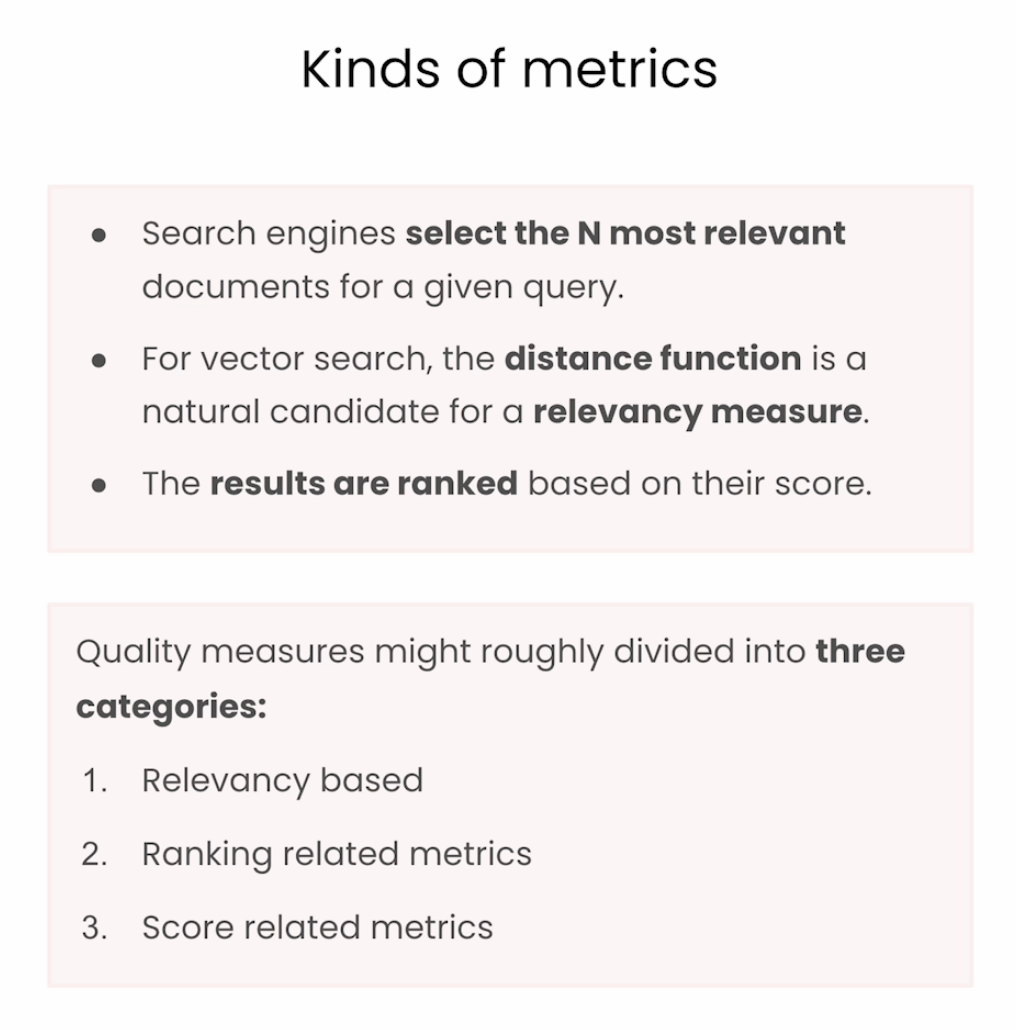
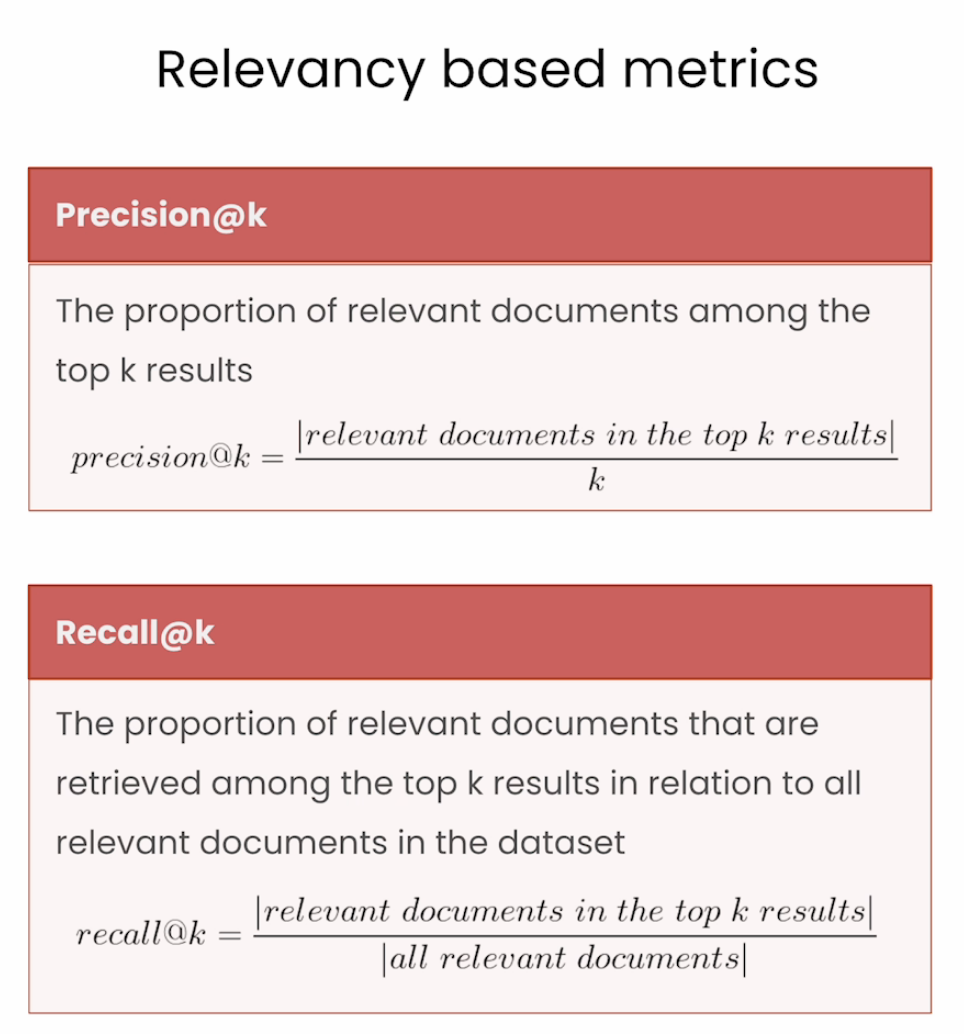
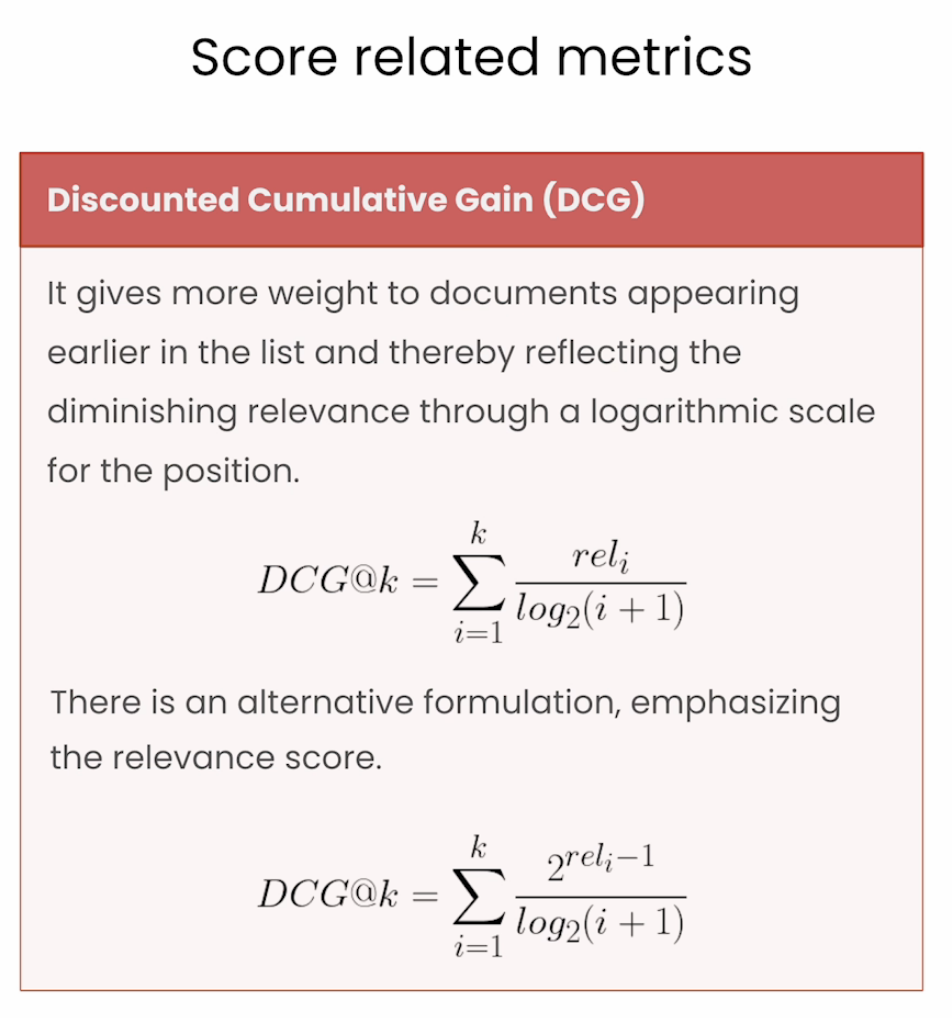
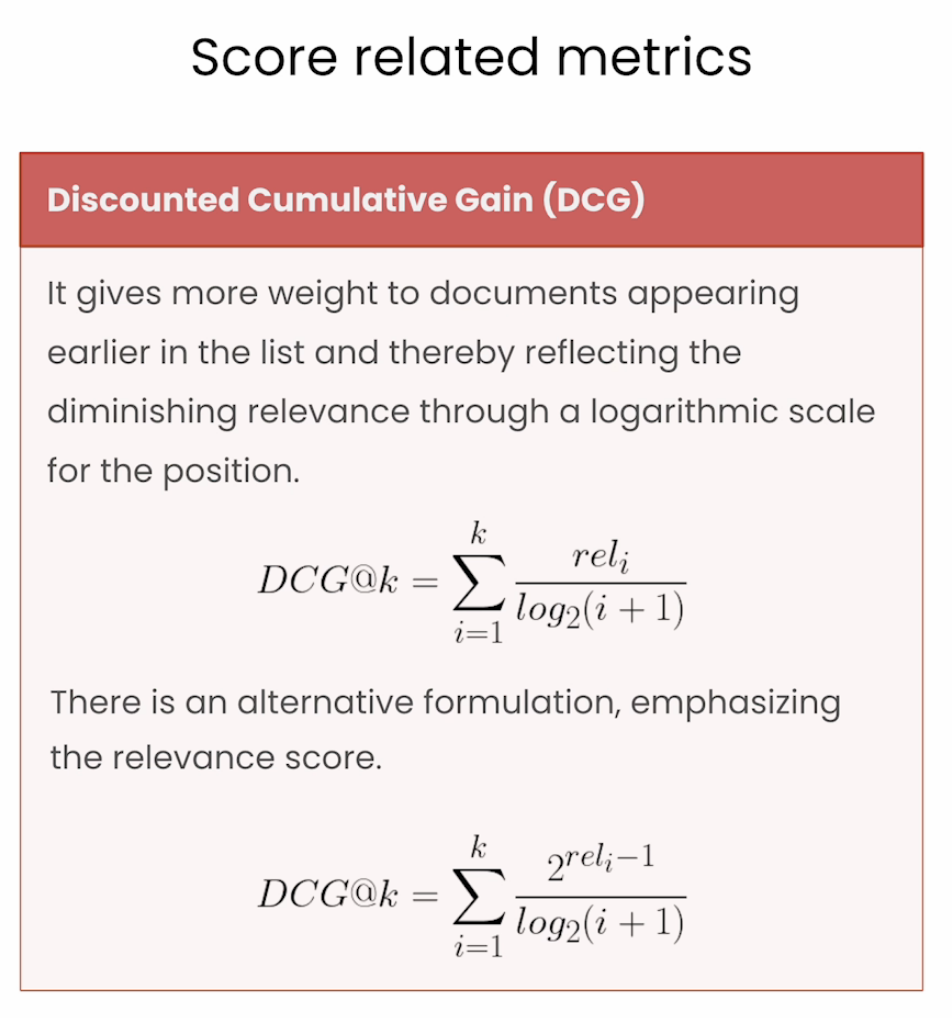

# ranx

In [21]:
from ranx import Qrels

qrels = Qrels.from_df(
    labels_df.astype({"query_id": "str", "product_id": "str"}),
    q_id_col="query_id",
    doc_id_col="product_id", 
    score_col="score",
)

In [16]:
queries_df["query_embedding"] = model.encode(
    queries_df["query"].tolist()
).tolist()
queries_df.sample(n=5)

query        query_class  \
query_id                                            
5            sofa with ottoman         Sectionals   
196       chabely 5 draw chest  Dressers & Chests   
346           nesting tray set   Decorative Trays   
345            oriental vanity    Makeup Vanities   
176                mexican art           Wall Art   

                                            query_embedding  
query_id                                                     
5         [0.120451420545578, 0.0037856982089579105, -0....  
196       [-0.0012300966773182154, 0.06464280933141708, ...  
346       [-0.007789288647472858, 0.07586026936769485, -...  
345       [0.07127071171998978, 0.09316759556531906, 0.0...  
176       [-0.0322100892663002, 0.08366059511899948, -0....

In [17]:
from collections import defaultdict

name_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        with_vectors=False,
        with_payload=False,
        limit=100,
    )

    for point in results:
        document_id = f"doc_{point.id}"
        name_run_dict[query_id][document_id] = point.score  
    
name_run_dict

defaultdict(dict,
            {'query_0': {'doc_4410': 0.7512183,
              'doc_4034': 0.744174,
              'doc_251': 0.7269764,
              'doc_2187': 0.72043705,
              'doc_975': 0.69298476,
              'doc_1616': 0.65913177,
              'doc_4444': 0.6508612,
              'doc_746': 0.648947,
              'doc_209': 0.64784795,
              'doc_2638': 0.6400894,
              'doc_1148': 0.63802826,
              'doc_1059': 0.6332265,
              'doc_1372': 0.63219,
              'doc_308': 0.63199496,
              'doc_603': 0.62417847,
              'doc_1742': 0.6134179,
              'doc_4938': 0.6115167,
              'doc_4330': 0.60891736,
              'doc_1259': 0.6060815,
              'doc_1864': 0.6024618,
              'doc_4329': 0.59796256,
              'doc_1373': 0.5947803,
              'doc_1454': 0.5935928,
              'doc_3604': 0.5926492,
              'doc_187': 0.58951074,
              'doc_206': 0.5892327,
           

In [18]:
from ranx import Run

product_name_run = Run(name_run_dict, name="product_name")

In [19]:
description_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_description", 
            vector=row["query_embedding"]
        ),
        with_vectors=False,
        with_payload=False,
        limit=100,
    )

    for point in results:
        document_id = f"doc_{point.id}"
        description_run_dict[query_id][document_id] = point.score 

product_description_run = Run(
    description_run_dict, 
    name="product_description"
)

In [22]:
from ranx import compare

compare(
    qrels=qrels,
    runs=[
        product_name_run, 
        product_description_run
    ],
    metrics=[
        "precision@10", 
        "recall@10", 
        "mrr@10",
        "dcg@10", 
        "ndcg@10",
    ],
)

/home/ubuntu/git-projects/personal/github.com/elasticsearch_opensearch/.venv/lib/python3.8/site-packages/ranx/metrics/precision.py:24: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  scores[i] = _precision(qrels[i], run[i], k, rel_lvl)


#    Model                P@10    Recall@10    MRR@10    DCG@10    NDCG@10
---  -------------------  ------  -----------  --------  --------  ---------
a    product_name         0.616ᵇ  0.034ᵇ       0.807ᵇ    19.131ᵇ   0.517ᵇ
b    product_description  0.457   0.024        0.687     14.493    0.388

# The above suggests that product_name affect relevancy more than product_description
- though we have to experiment with different values of k , differnt models, embedding methods and so on :) 